In [3]:
# 2019 NYC Airbnb Data (Source: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data) 
# How are prices, locations, and other factors correlated?
# In 2009, what kind of words did house owners use most often to describe their houses or rooms on the website?
# What kind of houses get more reviews? 
# Is a multilinear regression model apropos? 


# What kind of houses attract more guests? 
# What kind of users does Airbnb generally have?
# What kind of auspicious changes can Airbnb make to continue to attract guests?

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook"

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

df=pd.read_csv('AB_NYC_2019.csv')


In [5]:
df.head(3)

id                                 name  host_id  host_name  \
0  2539   Clean & quiet apt home by the park     2787       John   
1  2595                Skylit Midtown Castle     2845   Jennifer   
2  3647  THE VILLAGE OF HARLEM....NEW YORK !     4632  Elisabeth   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    149               1                  9  2018-10-19               0.21   
1    225               1                 45  2019-05-21               0.38   
2    150               3                  0         NaN                NaN   

   calculated_host_listings_count  availability_365  
0                               6               365  
1                               2               355  
2                               1               365

In [6]:
df.describe()

id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.190000   
50%          3.000000           5.000000           0.720000   
75%          5.000000          24.000000           2.020000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

In [7]:
print(df['room_type'].unique() )
print( df['neighbourhood_group'].unique())
df['neighb']=df['neighbourhood_group']+' '+df['neighbourhood'] #We can render this column useful for analysis later on.

['Private room' 'Entire home/apt' 'Shared room']
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


In [8]:
# Prices range up to $10K. There also seem to be $0 rentals. We can rectify these rows by removing them.
# Strange observation: out of 11 rows where price is $0, nine of them are in Brooklyn (mostly in Bedford-Stuyvesant and Bushwick).
# Rather this is a coincidence or not is outside of this scope of analysis. We can have Sherlock Holmes investigate this phenomenon- is 
# there a fraudulent activity running rife in Brooklyn or is it simply a bug, etc? 
df[df['price']==0]
zero_rental= df[df['price']==0].index
df=df.drop(zero_rental)


In [9]:
#There are no duplicated rows. We can remove the rows with booking availability=0 days. However, since there are too many rows (17530) and
#deleting huge chunk of data can be detrimental to our analysis,
#we will keep these rows for now. Note that houses with availability =0 days were likely available at some point in 2019 based on the
#dates of last reviews.
df.head(5)
print( 'Count Duplicated rows:', df.duplicated().sum())
print('Count zero availability: ',(df['availability_365']==0).sum())


Count Duplicated rows: 0
Count zero availability:  17530


In [10]:
#Setting up the dummy variables:
df[['room_type','neighborhood_group' ]]= df[['room_type','neighbourhood_group' ]].astype('category')

room=pd.get_dummies(df['room_type'])
room.drop(columns='Shared room',inplace=True, axis=1)
room.rename(columns={'Private room': 'private_room', 'Entire home/apt': 'entire'}, inplace=True)

area = pd.get_dummies(df['neighborhood_group'])
area.drop(columns='Queens',inplace=True, axis=1)
area.rename(columns=str.lower, inplace=True)
area.rename(columns={'staten island':'staten_island'}, inplace=True)

df= pd.concat( (df, area, room), axis=1)
df.columns
#To avoid multicollinearity, we drop one variable from 'room_type' and 'neightborhood_group'. Each categorical columns are now binary.

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighb', 'neighborhood_group', 'bronx', 'brooklyn',
       'manhattan', 'staten_island', 'entire', 'private_room'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of Airbnb Rentals in NYC')

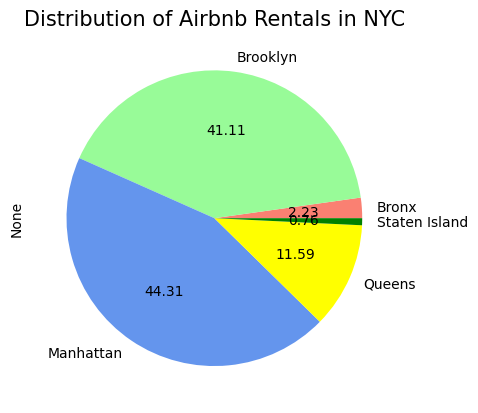

In [11]:
pii=df.groupby('neighborhood_group').size().plot(kind='pie',autopct='%.2f',colors=['salmon','palegreen','cornflowerblue','yellow','green'])
pii.set_title('Distribution of Airbnb Rentals in NYC', size=15)


In [12]:
#Prices by borough:
print('          percentile:      price:')
df.groupby('neighbourhood_group')['price'].quantile([.25,.50,.75])

          percentile:      price:


neighbourhood_group      
Bronx                0.25     45.0
                     0.50     65.0
                     0.75     99.0
Brooklyn             0.25     60.0
                     0.50     90.0
                     0.75    150.0
Manhattan            0.25     95.0
                     0.50    150.0
                     0.75    220.0
Queens               0.25     50.0
                     0.50     75.0
                     0.75    110.0
Staten Island        0.25     50.0
                     0.50     75.0
                     0.75    110.0
Name: price, dtype: float64

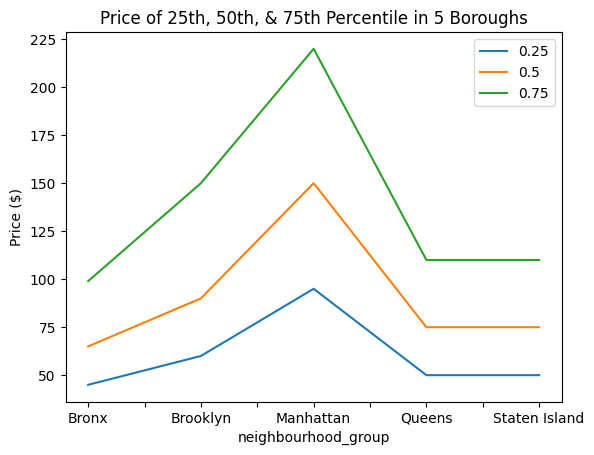

In [13]:
n_g = df.groupby('neighbourhood_group')
by_percentile = n_g['price'].quantile([.25,.50,.75]).unstack()
by_percentile.plot()
plt.title('Price of 25th, 50th, & 75th Percentile in 5 Boroughs')
plt.ylabel('Price ($)')
plt.show()

<AxesSubplot:xlabel='price', ylabel='Density'>

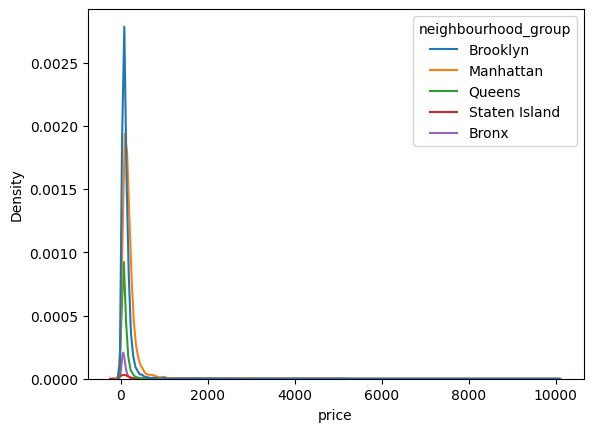

In [14]:
# Price Density Plot
sns.kdeplot(data=df, x='price',hue='neighbourhood_group')

In [15]:
df['price'].quantile([.05,.50,.95])

0.05     40.0
0.50    106.0
0.95    355.0
Name: price, dtype: float64

In [16]:
#Prices & locations:

# Overall, Airbnb prices per night are skewed far right. There are also outliers.
px.histogram(df,x='price', width=400, height=300, title='Price Distribution')

In [17]:
# We can observe how prices look after applying the log transformation. 
df=df.assign(log_price=np.log10(df['price']))
# We can also try excluding top and bottom 5% prices.
df2=df.copy(deep=True)
df2=df2.drop(df2[(df2['price']>355) ].index, axis=0) 
#df2 is the database where extreme 5% are trimmed.

In [18]:
#Log price distribution WITHOUT the 5% extremes removed:
px.histogram(df,x='log_price', width=350, height=250, title='Price Distribution')

In [19]:
# Log Price Distribution WITH 5% extremes excluded:
px.histogram(df2, x='log_price', width=350, height=250, title='Price Distribution')

In [20]:
print(df['log_price'].skew(), df2['log_price'].skew())

0.6081919263545469 -0.06905549839629266


In [21]:
#Where are the Airbnb houses with top 1% prices located?
df['price'].quantile([.99]) #This gives $799.
pd.set_option('display.max_rows', None)
one_percent= df[df['price']> 799]['neighb'].value_counts()
one_percent

Manhattan Upper West Side             43
Manhattan Midtown                     42
Manhattan West Village                30
Manhattan Chelsea                     29
Manhattan Upper East Side             25
Manhattan Hell's Kitchen              22
Manhattan Tribeca                     21
Manhattan SoHo                        21
Manhattan East Village                18
Brooklyn Bedford-Stuyvesant           16
Brooklyn Williamsburg                 15
Manhattan Harlem                      13
Manhattan Greenwich Village           13
Manhattan Gramercy                     9
Manhattan Theater District             9
Brooklyn Prospect Heights              7
Brooklyn Clinton Hill                  7
Manhattan Lower East Side              7
Manhattan Kips Bay                     7
Brooklyn Park Slope                    6
Manhattan Flatiron District            6
Manhattan Murray Hill                  6
Manhattan Financial District           6
Brooklyn Crown Heights                 5
Brooklyn Brookly

In [22]:
px.bar(one_percent, y='neighb', title='Locations of Top 1% Priced Airbnb Houses' )

In [23]:
df['price'].quantile([.01]) #This gives $30
px.bar(df[df['price']<30]['neighb'].value_counts(), y='neighb', title='Locations of Bottom 1% Priced Airbnb')

Some areas like Harlem, Bedford-Stuyvesant, Sunset Park, & Crownheights have houses with both top and lowest 1% prices. 

In [24]:
average_review=df['number_of_reviews'].mean()
print('Average number of reviews for all 2019 rentals ', average_review)

one_percent= df[df['price']> 799]['number_of_reviews'].mean()
print('Average number of reviews for 1% most expensive rentals ',one_percent)

Average number of reviews for all 2019 rentals  23.27199083544718
Average number of reviews for 1% most expensive rentals  8.905063291139241


In [25]:
#Locations with the Most Airbnb Rentals:
most_rent= df['neighb'].value_counts().nlargest(20).sort_values(ascending=True)
least_rent= df['neighb'].value_counts().nsmallest(20).sort_values(ascending=False)
px.bar(most_rent, x='neighb', title='Locations with the Most Rental Posts in NYC',labels={'neighb':'Rental Counts'} )

In [26]:
px.bar(least_rent, x='neighb', title='Locations with the Least Number of Airbnb Rental Posts in NYC',labels={'neighb':'Rental Counts'})

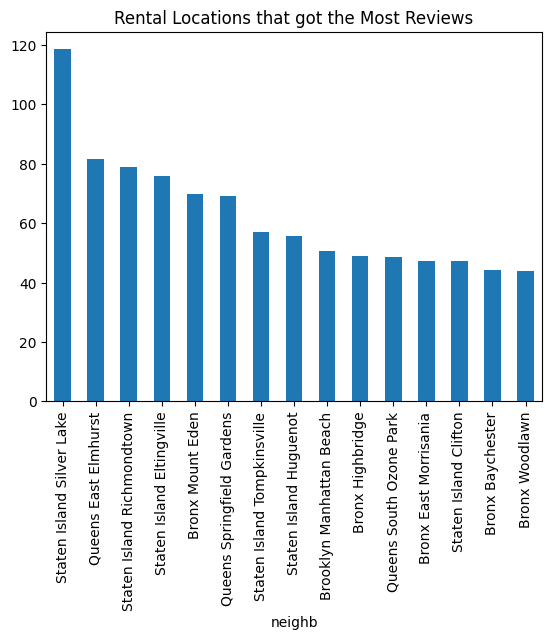

In [27]:
review_count=df.groupby('neighb')['number_of_reviews'].mean().nlargest(15).plot(kind='bar',title='Rental Locations that got the Most Reviews')


<AxesSubplot:title={'center':'Average Number of Reviews Per Borough'}, xlabel='neighbourhood_group'>

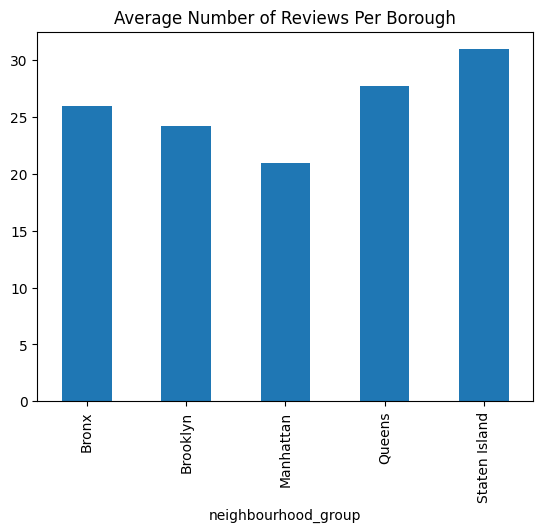

In [28]:
df.groupby('neighbourhood_group')['number_of_reviews'].mean().plot(kind='bar',title='Average Number of Reviews Per Borough')

In [29]:
# Which locations have the greatest 'minimum nights'? 
long_stay= df.loc[df['minimum_nights']>30, ['minimum_nights','neighb','price']]
px.scatter(long_stay, x='neighb',y='minimum_nights', hover_data=['price'], title='Locations that Require At Least a Month of Stay')
# Best locations to rent if staying over a month. Hover mouse over the graph to explore:

In [30]:
print('Percentage of Airbnb posts that require at least of month of stay: ',100* (df[df['minimum_nights']>30]['id'].count()/ df['id'].count()))

Percentage of Airbnb posts that require at least of month of stay:  1.5281073561901644


In [31]:
df[df['minimum_nights']>30]['number_of_reviews'].mean()

10.759036144578314

In [32]:
# A Quick look at the types of rooms and their price ranges:
# The graph is interactive and users can click on the colored dots on the legend. The axis automatically adjusts.
px.scatter(df, y='price', x='room_type', color='neighbourhood_group', width=400, height=500, title='Room Types and Price Ranges')

[Text(0.5, 1.0, 'The Median Price for Each Room Types in NYC Boroughs')]

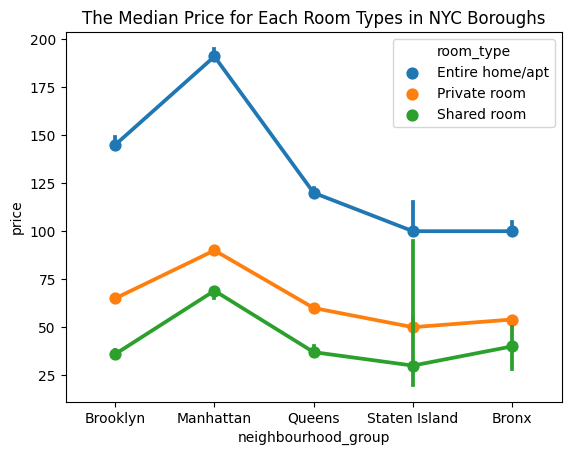

In [33]:
sns.pointplot(df, hue='room_type', y='price', x='neighbourhood_group', estimator=np.median).set(title='The Median Price for Each Room Types in NYC Boroughs')

In [34]:
#The distribution of reviews by room types. (You can click on the colored dots under the neightbourhood_group legend):
px.scatter(df, y='number_of_reviews', x='room_type', color='neighbourhood_group', width=400, height=500, title='Distribution of Number of Reviews by Room Type')

In [35]:
# Weighted average of reviews per room type:

print('Average number of reviews per room type:')
df.groupby('room_type')['number_of_reviews'].mean()

# People are on average, most likely to leave reviews for private rooms and least likely to leave reviews for shared rooms.

Average number of reviews per room type:


room_type
Entire home/apt    22.844098
Private room       24.104082
Shared room        16.622625
Name: number_of_reviews, dtype: float64

<AxesSubplot:xlabel='minimum_nights', ylabel='price'>

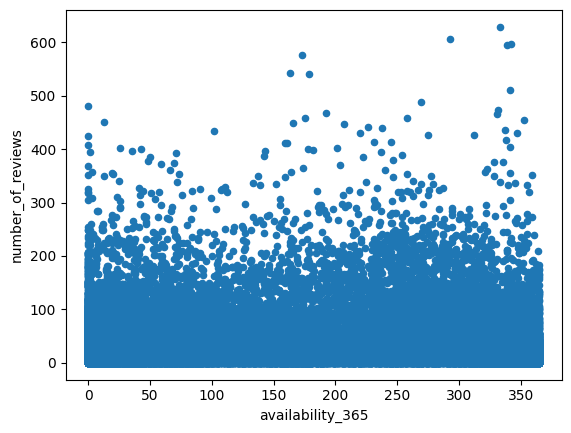

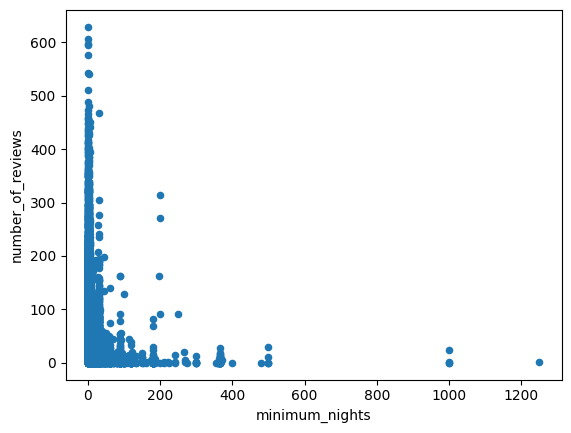

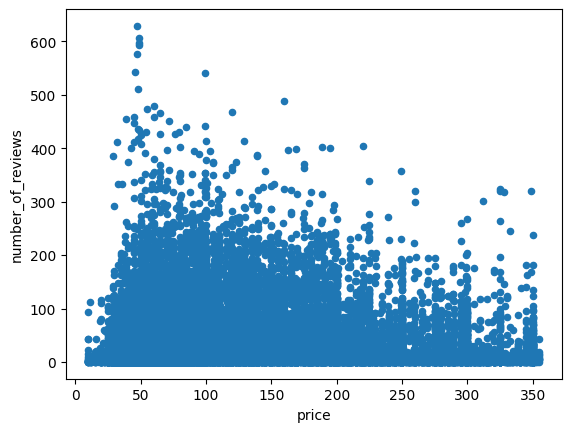

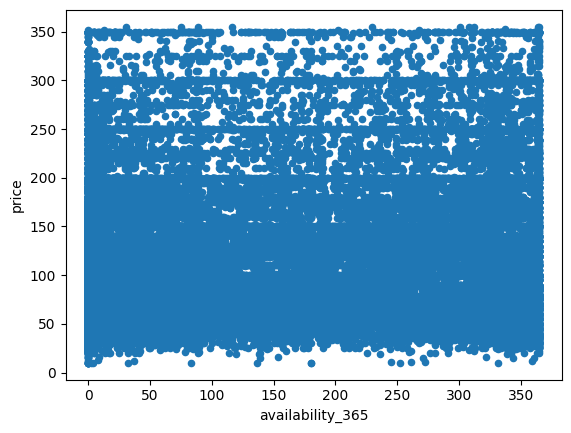

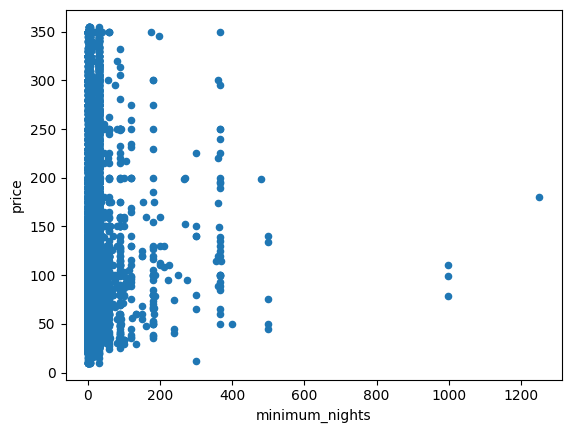

In [36]:
# Relationships through graphs:

df.plot.scatter(x='availability_365', y='number_of_reviews')
df.plot.scatter(x='minimum_nights', y='number_of_reviews')
df2.plot.scatter(x='price', y='number_of_reviews')
# There is no relationship between the number of days availabile for Airbnb and the number of reviews. This indicates that houses 
# that are available in Airbnb only a few days a year get as many reviews as those available throughout the year. 
# The houses that require smaller minimum nights get more wide range of reviews. Also, cheaper houses have more wide range of reviews in general. 
# However, there is not enough information to conclude that having more reviews equates to popularity (attracting more guests) since the rating is unknown.

df2.plot.scatter(x='availability_365', y='price')
df2.plot.scatter(x='minimum_nights', y='price')
#There is no particular correlation between price and availability of the house or minimum nights required.



In [37]:
# Text Analysis:
list=df['name'].copy(deep=True)
list=df['name'].dropna().str.split()

list_description=[]

for i in list:
    for word in i:
        list_description.append(word)

omit_list=['by','for','on','the','&','!','an','a','w/','and','of','to','in','with','from','park','studio','apt','room','home','apt:','upper','lower','apartment','house','new','york','manhattan','brooklyn','bronx','queens','state','island','bushwick','brownstone','bedroom','east','west','sout','north','williamsburg','chelsea','-','+','|','~','village']
# (Excludes location names, non-descriptive words like 'the', or nouns such as 'houses', 'room', or 'studio').
list=[]
for word in list_description:
    if word.lower() not in omit_list:
        list.append(word.lower())
df100=pd.DataFrame({'description_AirBnb':list})
list_desc= df100['description_AirBnb'].value_counts().nlargest(10)

fig=px.bar(list_desc, y='description_AirBnb', title='Top 10 most used description words in NYC Airbnb List (2019)').update_layout(xaxis_title='description_word', yaxis_title='count')
fig.update_traces(hovertemplate='word: %{x} <br>Count: %{y}')
fig.show()

In [38]:
#(More) common descriptions used in the 2009 NYC Airbnb List:
list_descr=df100['description_AirBnb'].value_counts().nlargest(50)
fig=px.bar(list_descr, y='description_AirBnb', title='Commonly used description words in NYC Airbnb List (2019)').update_layout(xaxis_title='description_word', yaxis_title='count')
fig.update_traces(hovertemplate='word: %{x} <br>Count: %{y}')
fig.show()

In [39]:
# NYC Airbnb lists that use top 10 common description words tend to have 2 less reviews on average than 
# the lists that do not use the top 10 common description words. 
mean_reviews=df['number_of_reviews'].mean()
print('Av number of reviews per Airbnb post in 2019: ', round(mean_reviews,0))


df['contains']= df['name'].str.contains('private|cozy|spacious|1|2|sunny|beautiful|near|heart|large|loft|nyc|central|modern|luxury|1br|bright|bed|charming|side', regex=True)


mean_reviews_ifcontains=df.loc[df['contains']==True]['number_of_reviews'].mean()
mean_reviews_notcontains=df.loc[df['contains']==False]['number_of_reviews'].mean()

print('Av number of reviews for rentals containing the top 20 common description words: ', round(mean_reviews_ifcontains,0))
print('Av number of reviews for rentals NOT containing the top 20 common description words',round(mean_reviews_notcontains,0))

Av number of reviews per Airbnb post in 2019:  23.0
Av number of reviews for rentals containing the top 20 common description words:  22.0
Av number of reviews for rentals NOT containing the top 20 common description words 24.0


In [40]:
df_corr= df[['log_price','bronx','brooklyn','manhattan', 'staten_island', 'entire', 'private_room','number_of_reviews','availability_365','minimum_nights']]
print(round( df_corr.corr(),2)) 
# There is overall a very small correlation between each independent variables and log_price.

                   log_price  bronx  brooklyn  manhattan  staten_island  \
log_price               1.00  -0.10     -0.19       0.35          -0.04   
bronx                  -0.10   1.00     -0.13      -0.13          -0.01   
brooklyn               -0.19  -0.13      1.00      -0.75          -0.07   
manhattan               0.35  -0.13     -0.75       1.00          -0.08   
staten_island          -0.04  -0.01     -0.07      -0.08           1.00   
entire                  0.62  -0.05     -0.07       0.16          -0.01   
private_room           -0.57   0.04      0.08      -0.16           0.01   
number_of_reviews      -0.04   0.01      0.02      -0.05           0.02   
availability_365        0.10   0.06     -0.08      -0.01           0.06   
minimum_nights          0.03  -0.02     -0.04       0.07          -0.01   

                   entire  private_room  number_of_reviews  availability_365  \
log_price            0.62         -0.57              -0.04              0.10   
bronx         

In [41]:
df_corr= df2[['log_price','bronx','brooklyn','manhattan', 'staten_island', 'entire', 'private_room','number_of_reviews','availability_365','minimum_nights']]
print(round( df_corr.corr(),2)) 
# Data where top 5% prices are removed: There is overall a very small correlation between each independent variables and log_price.

                   log_price  bronx  brooklyn  manhattan  staten_island  \
log_price               1.00  -0.11     -0.18       0.34          -0.05   
bronx                  -0.11   1.00     -0.13      -0.13          -0.01   
brooklyn               -0.18  -0.13      1.00      -0.74          -0.08   
manhattan               0.34  -0.13     -0.74       1.00          -0.08   
staten_island          -0.05  -0.01     -0.08      -0.08           1.00   
entire                  0.66  -0.05     -0.06       0.14          -0.01   
private_room           -0.60   0.04      0.07      -0.14           0.01   
number_of_reviews      -0.01   0.01      0.01      -0.04           0.02   
availability_365        0.05   0.06     -0.07      -0.02           0.06   
minimum_nights          0.02  -0.02     -0.04       0.07          -0.01   

                   entire  private_room  number_of_reviews  availability_365  \
log_price            0.66         -0.60              -0.01              0.05   
bronx         

In [42]:
# Checking of multicollinearity with VIF:
est_1 = smf.ols('number_of_reviews~ bronx+ brooklyn+ manhattan+ staten_island +entire+ private_room+ availability_365+ minimum_nights', df2).fit()
est_2 = smf.ols('bronx~ number_of_reviews+ brooklyn+ manhattan+ staten_island +entire+ private_room+ availability_365+ minimum_nights', df2).fit()
est_3 = smf.ols('brooklyn~ number_of_reviews+ bronx+ manhattan+ staten_island +entire+ private_room+ availability_365+ minimum_nights', df2).fit()
est_4 = smf.ols('manhattan~ number_of_reviews+ bronx+ brooklyn+ staten_island +entire+ private_room+ availability_365+ minimum_nights', df2).fit()
est_5 = smf.ols('staten_island~ number_of_reviews+ bronx+ brooklyn+ manhattan +entire+ private_room+ availability_365+ minimum_nights', df2).fit()
est_6 = smf.ols('entire~ number_of_reviews+ bronx+ brooklyn+ staten_island +manhattan+ private_room+ availability_365+ minimum_nights', df2).fit()
est_7 = smf.ols('private_room~ number_of_reviews+ bronx+ brooklyn+ staten_island +entire+ manhattan+ availability_365+ minimum_nights', df2).fit()
est_8 = smf.ols('availability_365~ number_of_reviews+ bronx+ brooklyn+ staten_island +entire+ private_room+ manhattan+ minimum_nights', df2).fit()
est_9 = smf.ols('minimum_nights~ number_of_reviews+ bronx+ brooklyn+ staten_island +entire+ private_room+ availability_365+ manhattan', df2).fit()

print('VIF:')
print(1/(1-est_1.rsquared))
print(1/(1-est_2.rsquared))
print(1/(1-est_3.rsquared))
print(1/(1-est_4.rsquared))
print(1/(1-est_5.rsquared))
print(1/(1-est_6.rsquared))
print(1/(1-est_7.rsquared))
print(1/(1-est_8.rsquared))
print(1/(1-est_9.rsquared))
est_10 = smf.ols('private_room~ number_of_reviews+ bronx+ brooklyn+ staten_island + manhattan+ availability_365+ minimum_nights', df).fit()
print("After omitting the 'entire' column: ", 1/(1-est_10.rsquared)) 

#The 'entire' column was omitted due to high multicollinearity in the model and the VIF improved significantly to 1.04

VIF:
1.0499288448147652
1.165504145027695
2.646675315927889
2.6851457983436853
1.0588726253302234
10.778780438916112
10.749818313202361
1.090188801208064
1.0473065383424278
After omitting the 'entire' column:  1.0334775467759048


In [43]:
# Lack of linearity and trend is a concern for OLS modeling but we will still proceed.
sns.pairplot(df2)

Multilinear Regression Model:

In [ ]:
#Multilinear Regression Model:
model = smf.ols('price~ number_of_reviews+ bronx+ brooklyn+ manhattan+ staten_island + private_room+ availability_365+ minimum_nights', df).fit()
model.summary()
#The adjusted R squared value is .084, which is very low indicating that the fit is poor.
#The p value for 'staten_island' and 'minimum_nights' are high at a=.05 and can be omitted.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     563.1
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:47:30   Log-Likelihood:            -3.3516e+05
No. Observations:               48884   AIC:                         6.703e+05
Df Residuals:                   48875   BIC:                         6.704e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           144.8596      3.540     40.916      0.000     137.920     151.799
number_of_reviews    -0.2897      0.024    -12.148      0.000      -0.336      -0.243
bronx               -15.8742      7.604     -2.088      0.037     -30.778      -0.970
brooklyn             21.9726      3.482      6.311      0.000      15.148      28.797
manhattan            77.3640      3.479     22.236      0.000      70.545      84.183
staten_island        -2.7214     12.295     -0.221      0.825     -26.820      21.378
private_room       -104.2496      2.122    -49.139      0.000    -108.408    -100.091
availability_365      0.1712      0.008     20.889      0.000       0.155       0.187
minimum_nights       -0.0020      0.052     -0.038      0.969      -0.103       0.099
==============================================================================
Omnibus:                   109596.624   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        946246619.239
Skew:                          21.100   Prob(JB):                         0.00
Kurtosis:                     683.284   Cond. No.                     2.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# The fit (adjusted R square=.084) did not improve.
# We can remove 'number_of_reviews' and 'availability_365' since we previously saw that they are non linear with price, but
# we will just keep it in the model since the F test p value is small.
model = smf.ols('price~  number_of_reviews+ bronx+ brooklyn+ manhattan+ private_room+ availability_365', df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     750.9
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:53:26   Log-Likelihood:            -3.3516e+05
No. Observations:               48884   AIC:                         6.703e+05
Df Residuals:                   48877   BIC:                         6.704e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           144.6884      3.456     41.866      0.000     137.915     151.462
number_of_reviews    -0.2896      0.024    -12.211      0.000      -0.336      -0.243
bronx               -15.7028      7.565     -2.076      0.038     -30.531      -0.875
brooklyn             22.1349      3.399      6.512      0.000      15.472      28.797
manhattan            77.5245      3.392     22.858      0.000      70.877      84.172
private_room       -104.2376      2.117    -49.229      0.000    -108.388    -100.087
availability_365      0.1711      0.008     21.173      0.000       0.155       0.187
==============================================================================
Omnibus:                   109595.531   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        946196425.396
Skew:                          21.099   Prob(JB):                         0.00
Kurtosis:                     683.266   Cond. No.                     1.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

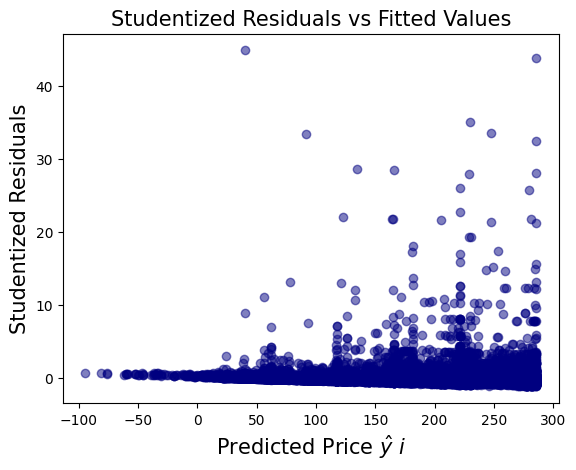

Resid mean:   2.4000161854492883e-12
Resid skew:   18.642953479097013


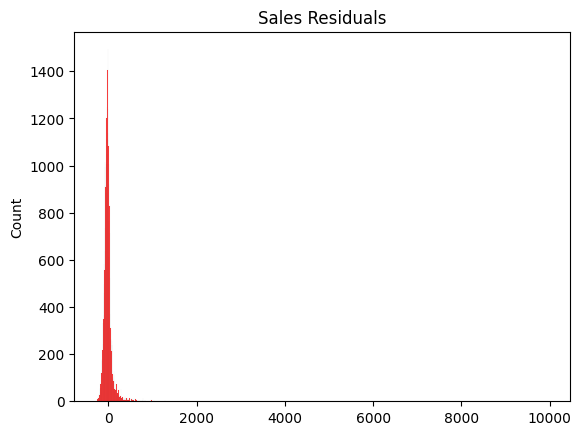

In [ ]:
#Fitting:
X=df[['number_of_reviews', 'brooklyn', 'manhattan','bronx','private_room' ,'availability_365']]
y=df['price']

from scipy.stats.stats import pearsonr 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=.25,random_state=7)
model1=sm.OLS(y_train, sm.add_constant(X_train)).fit()
influence=model1.get_influence()
#Residual vs Predicted Values: 
student_resid=influence.resid_studentized_external  
plt.scatter(x=model1.fittedvalues , y=model1.resid_pearson, c='navy',alpha=.5) #x=actual value, y=predicted value
plt.xlabel('Predicted Price $\hat y_ i$', fontsize=15)
plt.ylabel('Studentized Residuals', fontsize=15)
plt.title('Studentized Residuals vs Fitted Values',fontsize=15)
plt.show()

# Are residuals are centered around 0? Are they normally distributed? 
print("Resid mean:  ", model1.resid.mean())
print('Resid skew:  ',model1.resid.skew())
sns.histplot(model1.resid, color='red')
plt.title('Sales Residuals')
plt.show()


In [ ]:
# Without the log transformation of the price,
# the residuals plot does not show homoskedasticity (constant variance) and has conspicuous outliers.
# The residuals is skewed severly to the right instead of being normally 
# distributed (most points are greater than 3std above 0 while almost none are negative). 
# We can try improving the model by plotting using the log transformation of price.

Multilinear Regression Model with Log Transformation:

In [ ]:
# we will just keep number_of_reviews, availability_365, and minimum_nights in the model since the F test p value is small despite having almost no correlation.
model = smf.ols('log_price~ number_of_reviews+ bronx+ brooklyn+ manhattan+ staten_island + private_room+ availability_365+ minimum_nights', df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     4228.
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:03:42   Log-Likelihood:                 1822.6
No. Observations:               48884   AIC:                            -3627.
Df Residuals:                   48875   BIC:                            -3548.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.0584      0.004    573.164      0.000       2.051       2.065
number_of_reviews    -0.0003   2.42e-05    -12.221      0.000      -0.000      -0.000
bronx                -0.0614      0.008     -7.960      0.000      -0.077      -0.046
brooklyn              0.0677      0.004     19.182      0.000       0.061       0.075
manhattan             0.2104      0.004     59.616      0.000       0.203       0.217
staten_island        -0.0431      0.012     -3.455      0.001      -0.068      -0.019
private_room         -0.3166      0.002   -147.119      0.000      -0.321      -0.312
availability_365      0.0003   8.31e-06     33.337      0.000       0.000       0.000
minimum_nights       -0.0007   5.25e-05    -12.811      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     9143.220   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52191.882
Skew:                           0.783   Prob(JB):                         0.00
Kurtosis:                       7.814   Cond. No.                     2.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

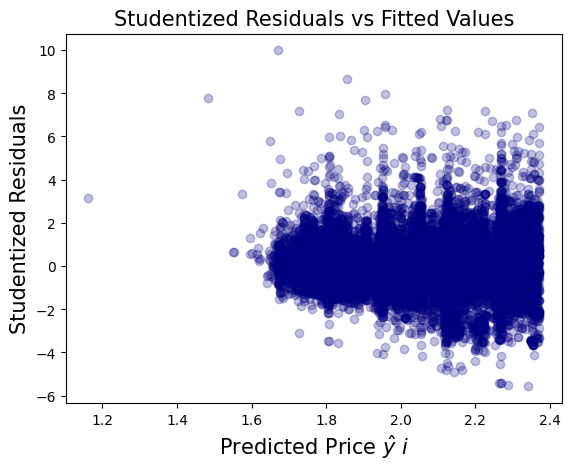

Resid mean:   -4.818930563422222e-15
Resid skew:   0.7909556698864759


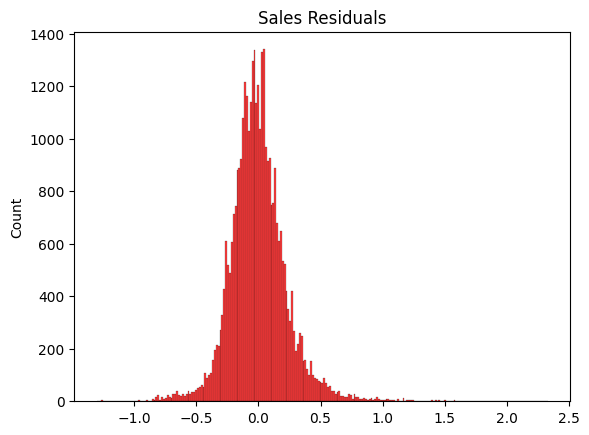

In [ ]:
X=df[['bronx','brooklyn', 'manhattan', 'staten_island' ,'private_room', 'availability_365','minimum_nights','number_of_reviews']]
y=df['log_price']

from scipy.stats.stats import pearsonr 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=.25,random_state=7)
model1=sm.OLS(y_train, sm.add_constant(X_train)).fit()
influence=model1.get_influence()
#Residual vs Predicted Values: 
student_resid=influence.resid_studentized_external  
plt.scatter(x=model1.fittedvalues , y=model1.resid_pearson, c='navy',alpha=.25) #switched alpha from .5
plt.xlabel('Predicted Price $\hat y_ i$', fontsize=15)
plt.ylabel('Studentized Residuals', fontsize=15)
plt.title('Studentized Residuals vs Fitted Values',fontsize=15)
plt.show()

#Residuals:
print("Resid mean:  ", model1.resid.mean())
print('Resid skew:  ',model1.resid.skew())
sns.histplot(model1.resid, color='red')
plt.title('Sales Residuals')
plt.show()
# Most residuals are within 3 standard deviations from the center despite being slightly skewed. There still exist
# conspicuous outliers and the data is almost homoskedastic.


Multilinear Regression Model with Log Transformation And Top 5% Outlier Prices Removed

In [ ]:
# The ajusted R squared of the model is .443 which is very low. These X variables do not explain log_price as well as we expect them to.
model = smf.ols('log_price~ number_of_reviews+ bronx+ brooklyn+ manhattan+ staten_island +private_room+ minimum_nights+ availability_365', df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     4615.
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:51:18   Log-Likelihood:                 10914.
No. Observations:               46443   AIC:                        -2.181e+04
Df Residuals:                   46434   BIC:                        -2.173e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.0412      0.003    684.920      0.000       2.035       2.047
number_of_reviews -7.789e-05   2.01e-05     -3.872      0.000      -0.000   -3.85e-05
bronx                -0.0610      0.006     -9.557      0.000      -0.073      -0.048
brooklyn              0.0584      0.003     19.980      0.000       0.053       0.064
manhattan             0.1792      0.003     60.989      0.000       0.173       0.185
staten_island        -0.0439      0.010     -4.243      0.000      -0.064      -0.024
private_room         -0.2877      0.002   -159.521      0.000      -0.291      -0.284
minimum_nights       -0.0007   4.57e-05    -14.984      0.000      -0.001      -0.001
availability_365      0.0002   7.09e-06     22.748      0.000       0.000       0.000
==============================================================================
Omnibus:                     2359.816   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5520.130
Skew:                          -0.318   Prob(JB):                         0.00
Kurtosis:                       4.564   Cond. No.                     2.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model = smf.ols('log_price~ bronx+ brooklyn+ manhattan+ staten_island +private_room+ availability_365', df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     6085.
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:27:14   Log-Likelihood:                 10800.
No. Observations:               46443   AIC:                        -2.159e+04
Df Residuals:                   46436   BIC:                        -2.152e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0375      0.003    688.873      0.000       2.032       2.043
bronx               -0.0601      0.006     -9.395      0.000      -0.073      -0.048
brooklyn             0.0573      0.003     19.541      0.000       0.052       0.063
manhattan            0.1769      0.003     60.178      0.000       0.171       0.183
staten_island       -0.0427      0.010     -4.115      0.000      -0.063      -0.022
private_room        -0.2859      0.002   -158.498      0.000      -0.289      -0.282
availability_365     0.0001   6.89e-06     20.376      0.000       0.000       0.000
==============================================================================
Omnibus:                     2279.288   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5204.321
Skew:                          -0.314   Prob(JB):                         0.00
Kurtosis:                       4.515   Cond. No.                     2.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Although we can ideally remove 'number of reviews', 'availability_365', and 'minimum nights' 
# since we previously observed that they're not related to the log price, we will just keep these variables 
# because the p values of the F statistic and individual X variables are significant and they do not affect the 
# adjusted R value much.

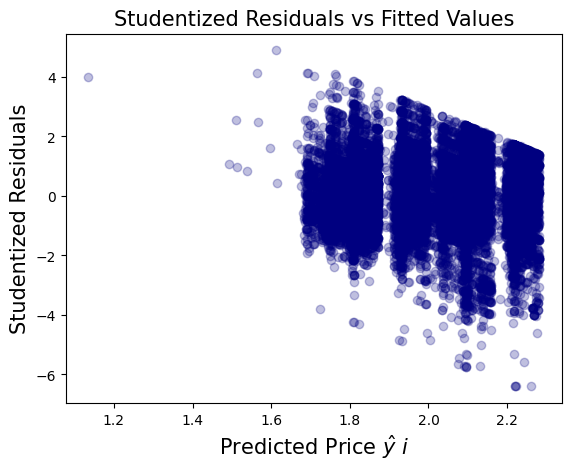

Resid mean:   -1.3851523919083086e-15
Resid skew:   -0.3027409623082787


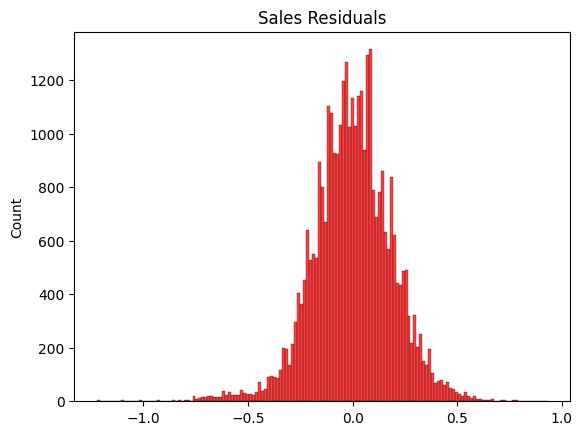

In [ ]:
#With Log Transformed Price with Top 5% Excluded:
X=df2[['bronx','brooklyn', 'manhattan', 'staten_island' ,'private_room', 'availability_365','minimum_nights','number_of_reviews']]
y=df2['log_price']

from scipy.stats.stats import pearsonr 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=.25,random_state=7)
model1=sm.OLS(y_train, sm.add_constant(X_train)).fit()
influence=model1.get_influence()
#Residual vs Predicted Values: 
student_resid=influence.resid_studentized_external  
plt.scatter(x=model1.fittedvalues , y=model1.resid_pearson, c='navy',alpha=.25) #switched alpha from .5
plt.xlabel('Predicted Price $\hat y_ i$', fontsize=15)
plt.ylabel('Studentized Residuals', fontsize=15)
plt.title('Studentized Residuals vs Fitted Values',fontsize=15)
plt.show()

#Residuals:
print("Resid mean:  ", model1.resid.mean())
print('Resid skew:  ',model1.resid.skew())
sns.histplot(model1.resid, color='red')
plt.title('Sales Residuals')
plt.show()


In [ ]:
# The residuals seem heteroskedastic with varying variances and is bad for OLS. Thus, we'll stick to the 2nd model.

Based on the analysis, the median NYC rentals are $106 a night and majority of the rental posts are from Brooklyn and Manhattan (together over 80%). Staten Island has the cheapest median prices for all room types and has the most average number of reviews (~31). On the other hand, Brooklyn and Manhattan tend to have the lowest average number of reviews.

The Airbnb posts that DO NOT use the 20 most common descriptive words, such as cozy, spacious, sunny, beautiful, large, and modern to name a few, get more reviews (we might want to study more to see if this is a coincidence). Furthermore, guests seem to be more inclined to write reviews when renting a private room. While there is not enough information to determine whether these reviews carry a positive or negative connotation or what percentage of guests actually write, having more information on these would be helpful in determining the impact of these reviews on Airbnb. By understanding what types of rental posts are associated with postive reviews, Airbnb can find ways to attract more guests. However, if we naively ASSUME that it is preferable to have more reviews, Airbnb can acquire this goal by ensuring that NYC posts for private rooms, especially modestly priced ones, appear in searches consistently throughout the year. 

Surprisingly, 1.52% of the posts require that guests stay over a month which can be appealing to international students or interns. Airbnb can try targeting these groups of guests and hosts gradually to grow.

While the multilinear regression model was not quite useful in predicting the price due to heteroskedastic residuals and lack of linearity between price and independent factors, the model could have been improved with lasso regression or tree regresison with ensemble. Since minimum nights, number of reviews, and availability have almost zero impact on price, the prediction is mostly driven by location and room types. The adjusted R^2, an indicator of the variability in price that can be explained by the variability in independent variables, is also low.

Other improvement Airbnb can work on is tracking the $0 rentals (why is the price $0? Is there a bug that needs to be fixed? Are users incessantly getting confused and making a mistake? Or is it intentional?).